# Unet training on custom datset

Clone into Unet's repository

In [14]:
import os
if not os.path.exists('pytorch_unet'):
    !git clone https://github.com/milesial/Pytorch-UNet pytorch_unet

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import torch
try:
    import wandb
except:
    %pip install wandb
    import wandb

### Dataset implementation

In [16]:
from pytorch_unet.utils.data_loading import *

class GazeboDataset(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, read_mask: bool, scale: float = 1.0, mask_suffix: str = ''):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        self.read_mask = read_mask
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

        logging.info(f'Creating dataset with {len(self.ids)} examples')
        logging.info('Scanning mask files to determine unique values')
        with Pool() as p:
            unique = list(tqdm(
                p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                total=len(self.ids)
            ))

        self.mask_values = list(sorted(np.unique(np.concatenate(unique), axis=0).tolist()))
        logging.info(f'Unique mask values: {self.mask_values}')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(mask_values, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)

        if is_mask:
            mask = np.zeros((newH, newW), dtype=np.int64)
            for i, v in enumerate(mask_values):
                if img.ndim == 2:
                    mask[img == v] = i
                else:
                    mask[(img == v).all(-1)] = i

            return mask

        else:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))

            if (img > 1).any():
                img = img / 255.0

            return img

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        img = load_image(img_file[0])
        
        if self.read_mask:
            assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
            mask = load_image(mask_file[0])
            img = load_image(img_file[0])

            assert img.size == mask.size, \
                f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'
            
            mask = self.preprocess(self.mask_values, mask, self.scale, is_mask=True)
            
        img = self.preprocess(self.mask_values, img, self.scale, is_mask=False)

        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous() if self.read_mask else None
        }

## Función de entrenamiento

In [17]:
import logging
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import wandb
from pytorch_unet.evaluate import evaluate
from pytorch_unet.unet import UNet
from pytorch_unet.utils.dice_score import dice_loss


# Use your datset path!
dir_img = Path('/home/gonz/monocular-2d-mapping/ros/dev_ws/src/gazebo_sim/images/images_raw')
dir_mask = Path('/home/gonz/monocular-2d-mapping/ros/dev_ws/src/gazebo_sim/images/images_segmented_flattened')
dir_checkpoint = Path('checkpoints/long/')

training_loss = []
validation_dice = []

val_percent = .2
batch_size = 16
img_scale = .5

# 1. Create dataset
try:
    dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
except (AssertionError, RuntimeError, IndexError):
    dataset = BasicDataset(dir_img, dir_mask, img_scale)

# 2. Split into train / validation partitions
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# 3. Create data loaders
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        save_freq: int = 1,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):

    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                training_loss.append(loss.item())

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)
                        validation_dice.append(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint and epoch % save_freq == 0:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}_bs16.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')

100%|██████████| 4192/4192 [00:40<00:00, 102.36it/s]


## Training

We have 6 classes:
- 0: Ground
- 1: Obstacle
- 2: Person
- 3: Building
- 4: Car
- 5: Sky/unknown

In [18]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')


# model = UNet(n_channels=3, n_classes=6, bilinear=False)
# model = model.to(memory_format=torch.channels_last)

# logging.info(f'Network:\n'
#                 f'\t{model.n_channels} input channels\n'
#                 f'\t{model.n_classes} output channels (classes)\n'
#                 f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

# model.to(device=device)

# train_model(
#             model=model,
#             epochs=200,
#             batch_size=16,
#             learning_rate=1e-6,
#             device=device,
#             save_freq=5,
#             amp=False
# )

## Evaluation

### Auxiliary funcitons

In [19]:
import random

def pred_to_numpy(x: np.ndarray):
    p = np.squeeze(x.T, axis=-1)
    return np.argmax(p, axis=-1).T

def get_n_evals(model, dataset, n_imgs, indices=None):
    model.eval()
    imgs        = []
    gt          = []
    predictions = []

    if indices is None:
        indices = random.sample(range(len(dataset)), n_imgs)
    
    for idx in indices:
        img  = dataset[idx]['image'] 
        mask = dataset[idx]['mask']
        if not img.is_cuda and next(model.parameters()).is_cuda: 
            img  = img.to(device) # match both devices
            mask = mask.to(device)
        
        pred = model(torch.unsqueeze(img, dim=0)) # add dataloader dim 1
        pred_numpy = pred_to_numpy(pred.detach().cpu().numpy())
        predictions.append(pred_numpy)
        
        imgs.append(img.cpu().detach().permute(1, 2, 0).numpy()) # convert to image format
        if mask is not None:
            gt.append(mask.cpu().numpy()) # convert to numpy
    
    return imgs, predictions, gt

def get_coincident_pixels(gt, pred):
    diff= np.abs(pred - gt)
    diff[diff > 0] = 1

    coincident = (diff.shape[0] * diff.shape[1] - np.count_nonzero(diff)) / (diff.shape[0] * diff.shape[1])
    
    print('coincident pixels: ', coincident)

    return diff, coincident

#### IoU calculation 

In [20]:
def compute_iou(predicted, target, num_classes):
    iou = torch.zeros(num_classes)
    
    for cls in range(num_classes):
        intersection = torch.logical_and(predicted == cls, target == cls).sum().item()
        union = torch.logical_or(predicted == cls, target == cls).sum().item()
        iou[cls] = intersection / union if union > 0 else 0.0
    
    mean_iou = iou.mean().item()
    return mean_iou, iou

def evaluate_iou(num_classes, dataloader, model):
    total_iou = 0.0
    num_batches = 0
    class_iou = torch.zeros(num_classes)

    for batch in dataloader:  # Iterate over your validation or test set
        inputs, targets = batch['image'], batch['mask']
        with torch.no_grad():
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)

        batch_iou, batch_class_iou = compute_iou(predictions, targets, num_classes)
        
        total_iou += batch_iou
        class_iou += batch_class_iou
        num_batches += 1

    mean_iou = total_iou / num_batches
    mean_class_iou = class_iou / num_batches

    print(f"Mean IoU: {mean_iou:.4f}")
    print("Per-Class IoU:")
    for cls, iou in enumerate(mean_class_iou):
        print(f"Class {cls}: {iou:.4f}")

    return mean_iou, mean_class_iou


### Evaluation

In [21]:
checkpoint = torch.load('checkpoints/checkpoint_epoch200_bs16.pth')
checkpoint.pop('mask_values')
model_ep1 = UNet(n_channels=3, n_classes=6, bilinear=False)
model_ep1.load_state_dict(checkpoint)

<All keys matched successfully>

coincident pixels:  0.9947786458333333
coincident pixels:  0.990234375
coincident pixels:  0.96734375
coincident pixels:  0.9954296875
coincident pixels:  0.9939192708333333
overlap average:  0.9883411458333333


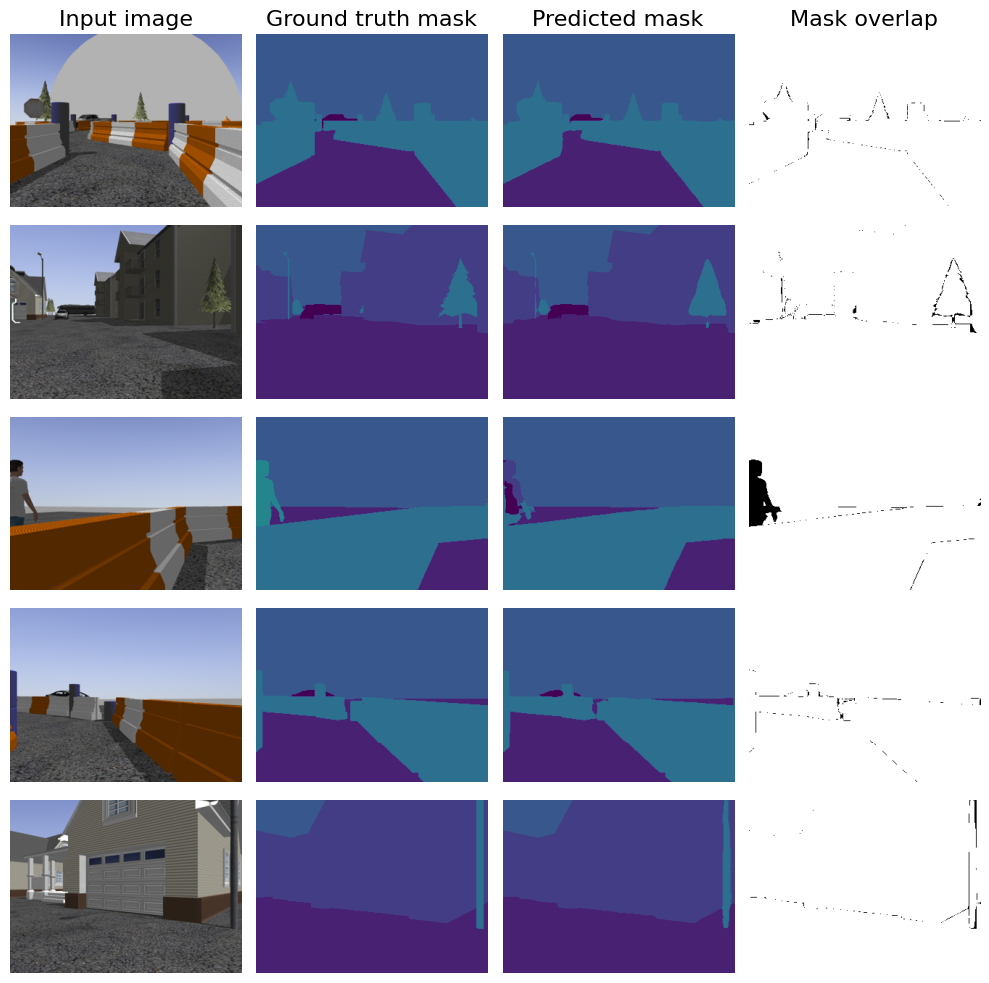

In [25]:
rand_ids = random.sample(range(len(val_set)), 5)
imgs, pred, gts = get_n_evals(model_ep1, val_set, n_imgs=5, indices=rand_ids)
overlap_avg     = [] 

fig, axes = plt.subplots(len(imgs), 4, figsize=(10, 10))
for i in range(len(imgs)):
    axes[i][0].imshow(imgs[i])
    axes[i][0].axis('off')
    axes[i][1].imshow(gts[i], vmin=0, vmax=11)
    axes[i][1].axis('off')
    axes[i][2].imshow(pred[i], vmin=0, vmax=11)
    axes[i][2].axis('off')

    overlap, overlap_percent = get_coincident_pixels(gts[i], pred[i])
    overlap_avg.append(overlap_percent)
    axes[i][3].imshow(np.ones_like(overlap) - overlap, vmin=0, vmax=1, cmap='gray')
    axes[i][3].axis('off')

axes[0][0].set_title('Input image', fontsize=16)
axes[0][1].set_title('Ground truth mask', fontsize=16)
axes[0][2].set_title('Predicted mask', fontsize=16)
axes[0][3].set_title('Mask overlap', fontsize=16)
fig.tight_layout()

print('overlap average: ', sum(overlap_avg) / len(overlap_avg))

In [9]:
for batch in val_loader:  # Iterate over your validation or test set
        inputs, targets = batch['image'], batch['mask']
        with torch.no_grad():
            outputs = model_ep1(inputs)
            predictions = torch.argmax(outputs, dim=1)
            break

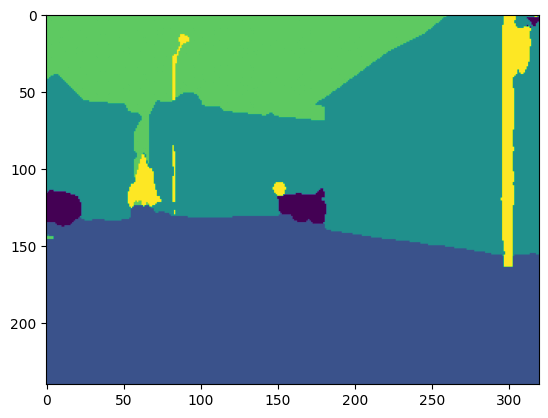

In [16]:
plt.imshow(predictions[4])

#### IoU calculation

In [10]:
evaluate_iou(6, val_loader, model_ep1)

Mean IoU: 0.7975
Per-Class IoU:
Class 0: 0.9094
Class 1: 0.9786
Class 2: 0.9741
Class 3: 0.9784
Class 4: 0.8902
Class 5: 0.0544


(0.7975207509902807, tensor([0.9094, 0.9786, 0.9741, 0.9784, 0.8902, 0.0544]))

In [11]:
len(val_loader)

52

In [12]:
evaluate_iou(6, train_loader, model_ep1)

Mean IoU: 0.7961
Per-Class IoU:
Class 0: 0.9074
Class 1: 0.9769
Class 2: 0.9691
Class 3: 0.9737
Class 4: 0.8752
Class 5: 0.0743


(0.7960964063803355, tensor([0.9074, 0.9769, 0.9691, 0.9737, 0.8752, 0.0743]))

## Inference functions

In [37]:
def predict_frame(model, img):
    model.eval()

    if not img.is_cuda and next(model.parameters()).is_cuda: 
        img  = img.to(device) # match both devices

    pred = model(torch.unsqueeze(img, dim=0)) # add dataloader dim 1
    pred = torch.argmax(pred, dim=1)

    return pred.detach().cpu().numpy()[0]

In [50]:
from time import time 

avg = []
for _ in range(10):
    t_s = time()
    _ = predict_frame(model_ep1, train_set[0]['image'])
    avg.append(time() - t_s)
    
print('avg time:', sum(avg) / len(avg))

avg time: 0.18152482509613038


## solo pa hacerlo mas pretty

In [35]:
def map_classes(img):
    img_rgb = np.zeros((img.shape[0], img.shape[1], 3))
    img_rgb[img==0, 2] = 255
    img_rgb[img==1, 1] = 255
    img_rgb[img==2, 1] = 255
    img_rgb[img==2, 2] = 255
    img_rgb[img==3, :] = 127
    img_rgb[img==4, 0] = 255
    return img_rgb

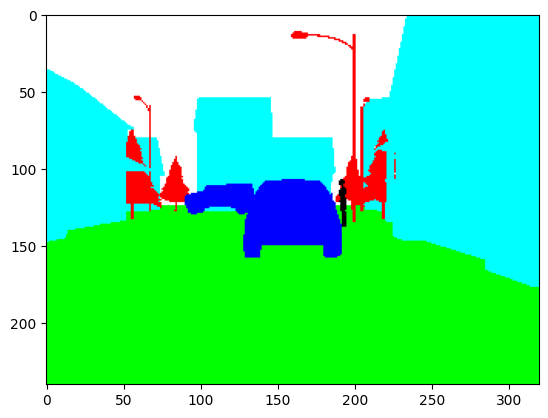

In [42]:
plt.imshow(map_classes(val_set[91]['mask']))

In [ ]:
a = predict_frame(model_ep1, val_set[91]['image'])
# b = map_classes(a)
plt.imshow(a==4)
np.unique(a)

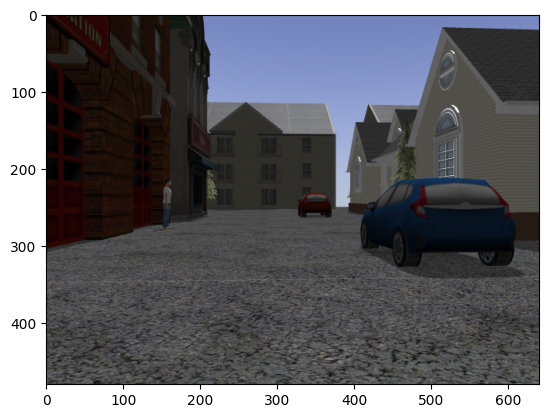

In [32]:
import cv2 as cv
from PIL import Image

img = cv.imread('../../test_images/image.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img)

In [33]:
from torchvision.transforms import Resize
img_tensor = GazeboDataset.preprocess(mask_values=False, pil_img=Image.fromarray(img), scale=.5, is_mask=False)
img_tensor = torch.tensor(img_tensor, dtype=torch.float32)
img_tensor.shape

torch.Size([3, 240, 320])

array([0, 1, 2, 3, 4, 5])

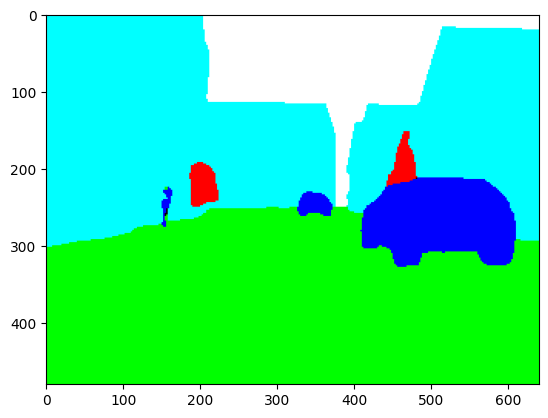

In [38]:
img = map_classes(predict_frame(model_ep1, img_tensor))
img_gray = predict_frame(model_ep1, img_tensor)

# img_gray += 1

bev_image = cv.resize(img_gray.astype(np.uint8), (640, 480), interpolation=cv.INTER_AREA)
plt.imshow(map_classes(bev_image))
np.unique(img_gray)